In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from kneed import KneeLocator
import seaborn as sns
from constants import stablecoins

In [78]:
#Change this variable to True for save plot images
save_images = True

## Data processing

### Read data

In [79]:
df = pd.read_csv("all_coins_data.csv")
df = df[["time","daily_log_return", "coin"]]

In [80]:
df_pivoted = df.pivot(index="coin", columns="time", values="daily_log_return")
df_pivoted.head()

time,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,...,2021-04-15,2021-04-16,2021-04-17,2021-04-18,2021-04-19,2021-04-20,2021-04-21,2021-04-22,2021-04-23,2021-04-24
coin,,,,,,,,,,,,,,,,,,,,,
ADA,0.019340,-0.030797,0.017945,-0.094018,0.015859,-0.064072,0.021209,0.061912,0.008540,0.041638,...,0.018412,-0.047035,-0.028009,-0.070920,-0.067096,0.059247,-0.052580,-0.050245,0.012153,-0.027111
ALGO,0.061710,0.083686,0.025879,-0.114357,-0.021398,-0.053381,0.023308,0.000562,-0.030216,-0.031357,...,0.071176,-0.041564,0.118078,-0.149741,-0.120610,0.000000,-0.065414,-0.038660,0.000857,-0.035734
ATOM,0.136226,0.283939,-0.039202,0.022299,-0.083755,-0.056663,0.037690,-0.039612,0.048555,-0.058083,...,0.027688,-0.086652,-0.044879,-0.128392,-0.107122,0.099639,-0.082158,-0.044290,0.090114,-0.045315
BCH,0.013840,-0.007142,0.021790,-0.052907,-0.003777,-0.037703,0.015743,-0.002197,0.040682,-0.020645,...,0.061542,0.243818,-0.109446,-0.016340,-0.089443,0.054295,-0.033778,-0.063267,-0.016707,-0.027415
BNB,0.007227,-0.016792,0.034191,-0.054534,0.037135,0.040138,-0.001731,-0.005211,0.028751,-0.020945,...,-0.012386,-0.063653,0.012574,-0.067041,0.045586,0.154173,-0.079246,-0.073323,0.042354,-0.026840


In [81]:
df_pivoted.shape

(45, 246)

### Normalize Series

In [82]:
# convert dataframe to time_series_dataset
X = to_time_series_dataset(df_pivoted.values)

# normalize time series to zero mean and unit variance
X_train = TimeSeriesScalerMeanVariance().fit_transform(X)


### Clustering

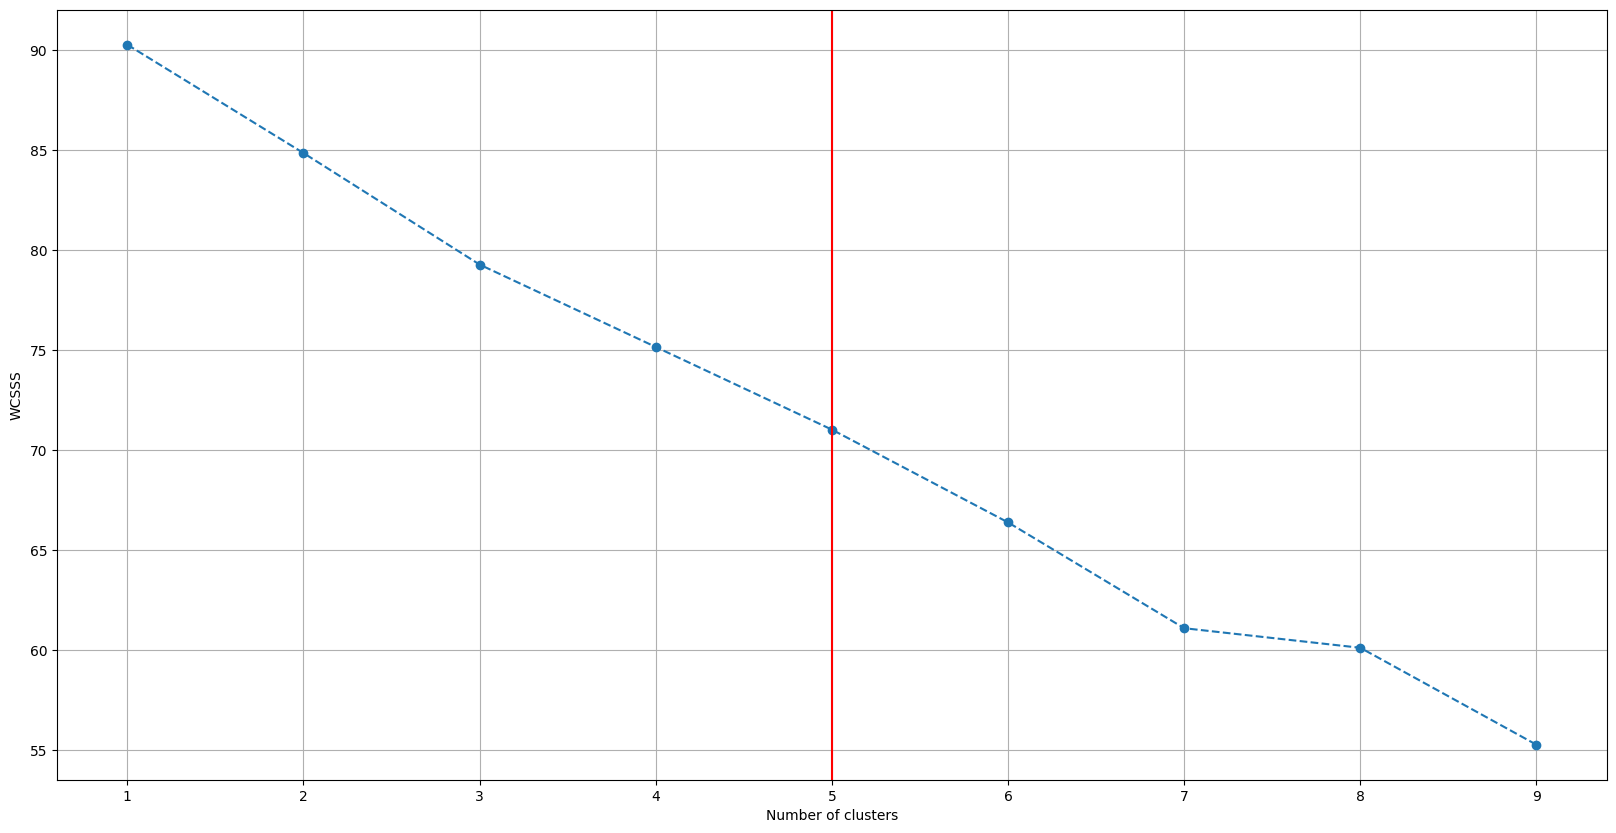

In [83]:
algo = "DTW_kmeans"
metric = "dtw"

wcss = []

for i in range(1,10):
    model= TimeSeriesKMeans(n_clusters=i,metric=metric,n_jobs=-1,random_state=0)
    model.fit_predict(X_train)
    wcss.append(model.inertia_)

kneedle = KneeLocator(x = range(1, 10), y = wcss, curve="concave", direction="decreasing", online = True)
print()

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1,10),wcss,marker='o',linestyle='--')
plt.axvline(x=kneedle.knee, color = "red")
plt.xlabel('Number of clusters')
plt.ylabel('WCSSS')
if save_images:
    plt.savefig("images/knee_cluster.png", format="PNG")

### Clustering selection

In [84]:
algo = "DTW_kmeans"
metric = "dtw"

# cluster configuration
N_CLUSTERS = 5

model= TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                        metric=metric,
                        n_jobs=-1,
                        random_state=0)

y_pred = model.fit_predict(X_train)


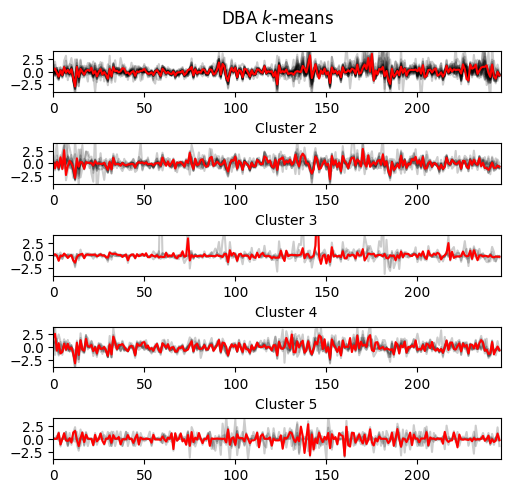

In [85]:
for yi in range(5):
    plt.subplot(5, 1, 1+yi)
    plt.subplots_adjust(left=0.2,bottom=0.05, 
                        right=0.9, top=0.9, wspace=0.4, hspace=1.25)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train.shape[1])
    plt.ylim(-4,4)
    plt.text(0.45, 1.25,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means", pad = 20)

if save_images:
    plt.savefig("images/DTW_clusters.png", format="PNG")

### Result Analysis

In [86]:
df_pivoted["cluster"] = y_pred
cluster_results = df_pivoted.reset_index()[["coin", "cluster"]].set_index("coin")

In [87]:
df_cluster = df.merge(cluster_results, on = "coin")
df_cluster = df_cluster.groupby(["coin", "cluster"]).agg({"daily_log_return":["mean", "std"]}).reset_index()
df_cluster.columns = df_cluster.columns.droplevel()
df_cluster.columns = ["Coin","cluster","mean_return","volatility"]

In [88]:
df_cluster[df_cluster["Coin"].isin(stablecoins)]

,Coin,cluster,mean_return,volatility
7,BUSD,4,-4.065651e-07,0.000738
10,DAI,1,-2.025436e-05,0.002454
32,TUSD,1,4.065244e-07,0.001098
34,USDC,4,4.054740e-19,0.000709
35,USDT,4,4.876099e-06,0.000864


c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inste

<Figure size 640x480 with 0 Axes>

c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\feder\anaconda3\envs\graph\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


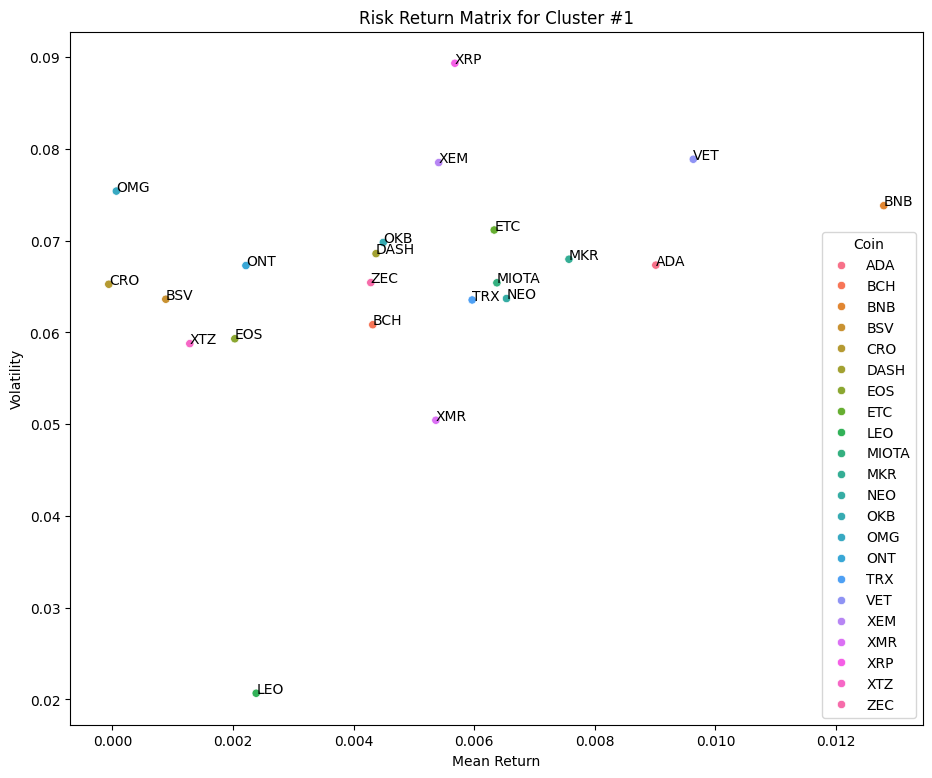

<Figure size 640x480 with 0 Axes>

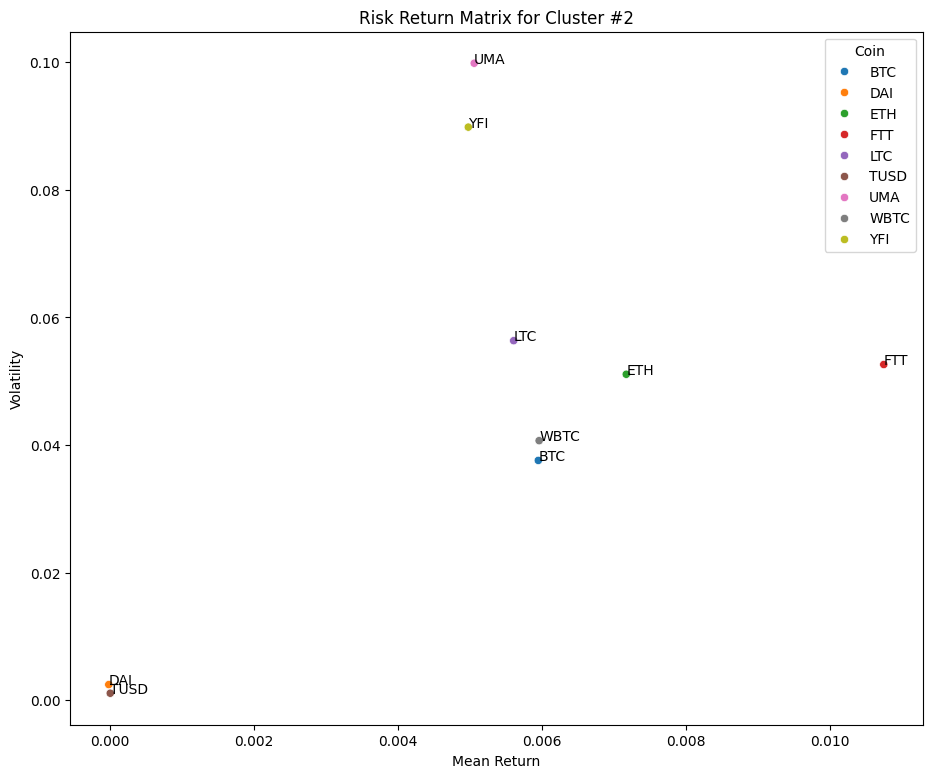

<Figure size 640x480 with 0 Axes>

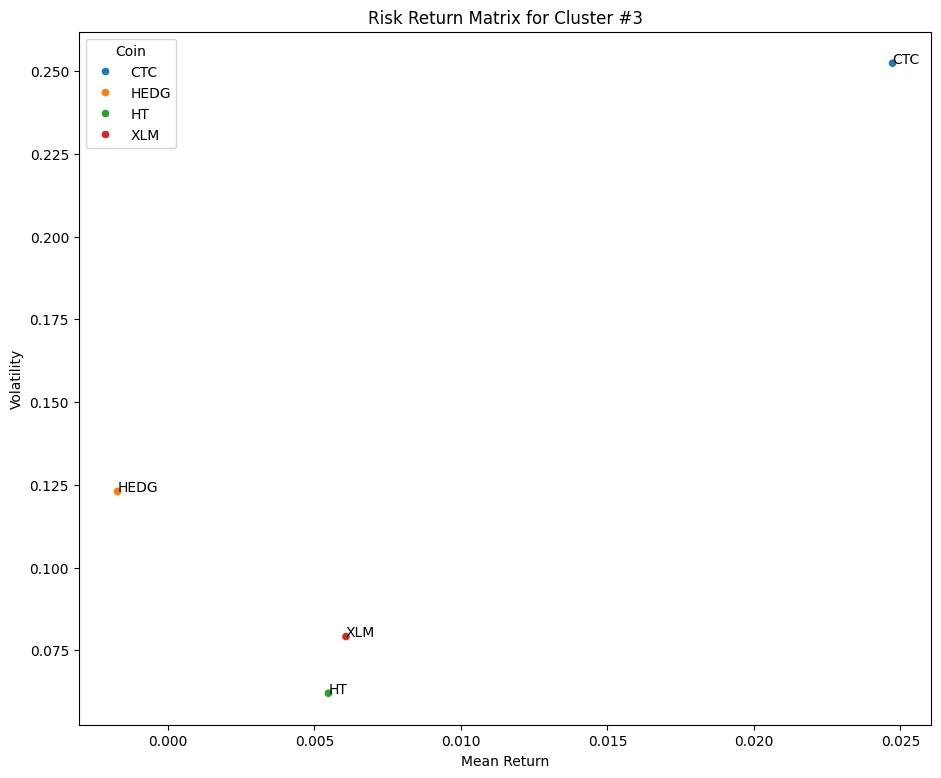

<Figure size 640x480 with 0 Axes>

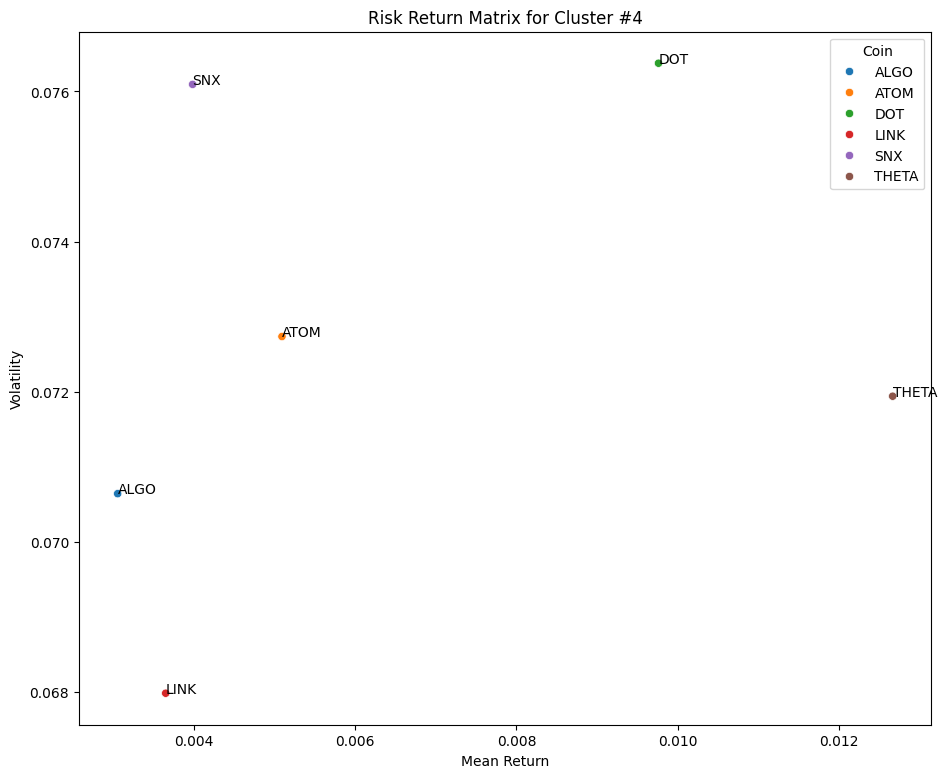

<Figure size 640x480 with 0 Axes>

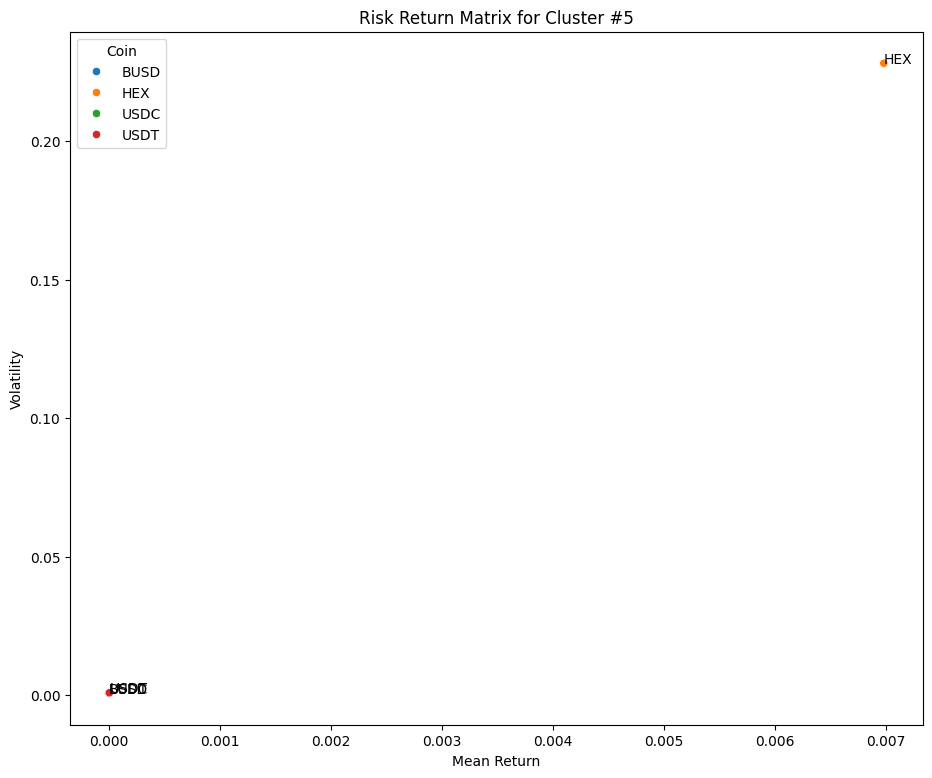

In [89]:
for c in range(0,5):
    plt.figure()
    f, ax = plt.subplots(figsize=(11, 9))
    sns.scatterplot(data = df_cluster[df_cluster["cluster"]==c], x = "mean_return", y = "volatility", hue = "Coin")
    ax.set(xlabel="Mean Return", ylabel="Volatility")
    ax.set_title("Risk Return Matrix for Cluster #" + str(c+1))
    
    labels = df_cluster[df_cluster["cluster"]==c]["Coin"].tolist()
    for i, label in enumerate(labels):
        plt.annotate(label, (df_cluster[(df_cluster["cluster"]==c) & (df_cluster["Coin"]==label)]["mean_return"], df_cluster[(df_cluster["cluster"]==c) &  (df_cluster["Coin"]==label)]["volatility"]))
    if save_images:
        plt.savefig("images/cluster_"+str(c+1)+".png", format="PNG")